### 캘리포니아 주택 가격 예측
인구, 중간소득 등의 특성을 활용하여 중간 주택가격예측     

레이블된 훈련 샘플이 있고 값을 예측해야하는 문제이기 때문에 지도학습의 회귀 문제이다. 사용할 특성이 여러개이기 때문에 단변량회귀, 구역마다 여러 값을 예측한다면 다변량 회귀문제 입니다. 시스템으로 들어오는 데이터에 연속적인 흐름이 없으므로 빠르게 변하는 데이터에 적응하지 않아도 되고 , 데이터가 메모리에 들어갈 만큼 충분히 작으므로 일반적인 배치 학습이 적절합니다.

#### 성능 지표 선택
회귀문제의 전형적인 성능 지표는 평균제곱오차(RMSE) 오차가 커질 수록 이 값은 더욱 커지므로 예측에 얼마나 많은 오류가 있는지 가늠하게 해준다.  
평균절대오차(MAE) 이상치로 보이는 구역이 많을 시 유용

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
df = pd.read_csv('data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<AxesSubplot:>

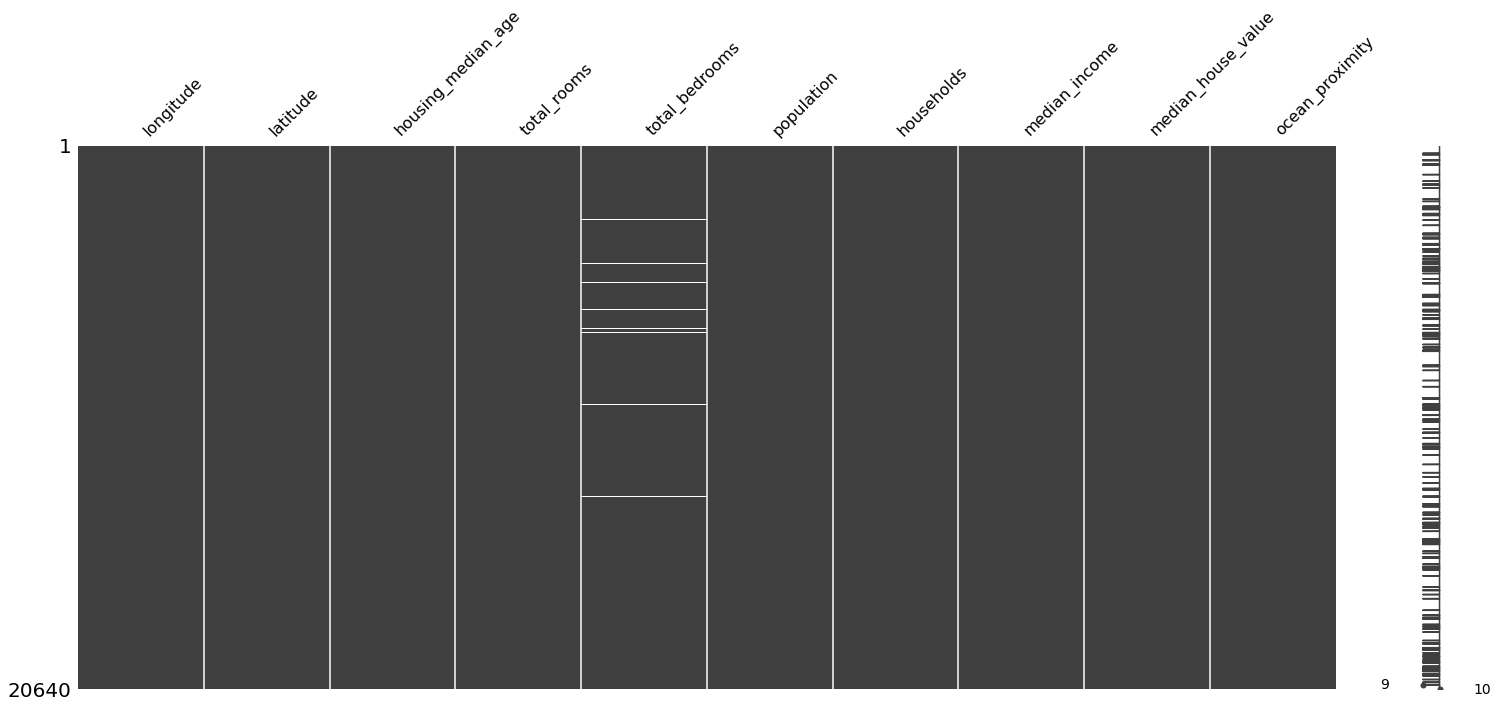

In [5]:
# null 값 시각화
import missingno as msno

msno.matrix(df)

In [6]:
# null 값 보기 
tot = df.isnull().sum().sort_values(ascending=False)
pct = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([tot, pct], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
total_bedrooms,207,0.010029
longitude,0,0.000000
latitude,0,0.000000
housing_median_age,0,0.000000
total_rooms,0,0.000000
population,0,0.000000
households,0,0.000000
median_income,0,0.000000
median_house_value,0,0.000000
ocean_proximity,0,0.000000


In [7]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
df.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


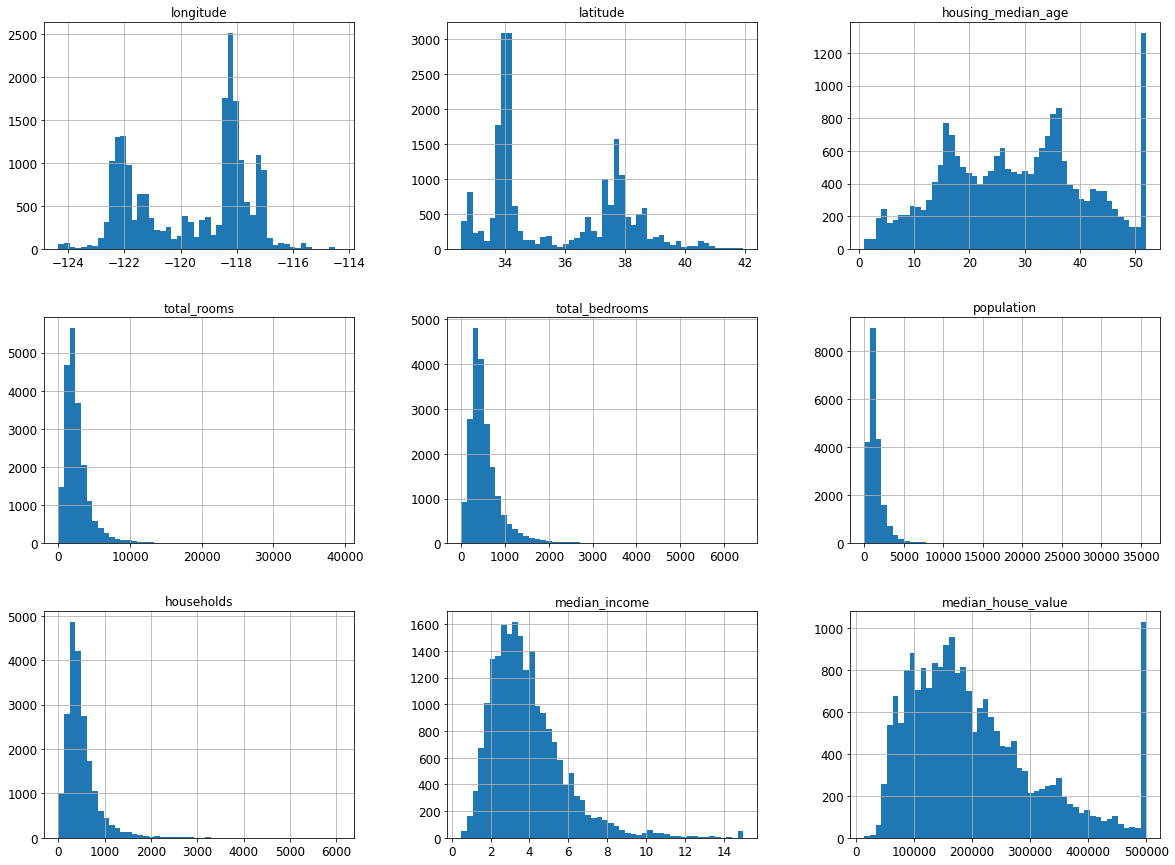

In [9]:
# 수치형 데이터 히스토그램
# housing_median_age , median_house_value 최소값과 최댓값이 한정되어 있다.
# 컬럼값들의 단위가 다름으로 스케일링 필요 
# 정상적인 가우시안분포를 갖고 있지 않고 왼쪽으로 치우침이 있기 때문에 조정 필요 이런 형태는 일부 머신러닝 알고리즘에서 
# 패턴을 찾기 어렵게 만들기 때문에 특성들을 좀 더 종 모양의 분포가 되도록 변형 요망  

df.hist(bins=50, figsize=(20,15))
plt.show()

### Testset 

In [10]:
# train_test_split 함수 

def split_train_test(data, test_ratio):
    # permutation (순열) 정수배열을 랜덤하게 섞는다.
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(df, 0.2)
len(train_set)

16512

In [12]:
len(test_set)

4128

In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [15]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [16]:
housing_with_id = df.reset_index()   # `index` 열이 추가된 데이터프레임을 반환합니다
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [17]:
housing_with_id["id"] = df["longitude"] * 1000 + df["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")


In [18]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [19]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

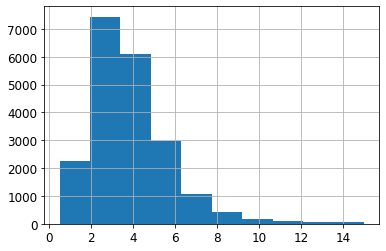

In [20]:
df["median_income"].hist()
plt.show()

In [21]:
# 중요도가 높은 컬럼인 median_income을 수치형에서 카테고리로 변경 ,여러 소득 카테고리를 대표하기 위해서
df['income_cat'] = pd.cut(df['median_income'] , bins = [0.,1.5,3.0,4.5,6, np.inf], labels =[1,2,3,4,5,])

In [22]:
df['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

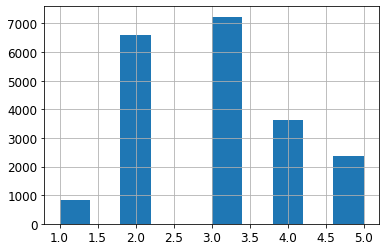

In [23]:
df['income_cat'].hist()
plt.show()

In [24]:
# 새로 생성한 imcome_cat 컬럼을 test, train에 균등하게 나누는 계층적 샘플링

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [26]:
df["income_cat"].value_counts() / len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [27]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### EDA 탐색적 분석

In [29]:
# 원본 데이터 손상을 막기 위해 copy 

h = strat_train_set.copy()
h.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


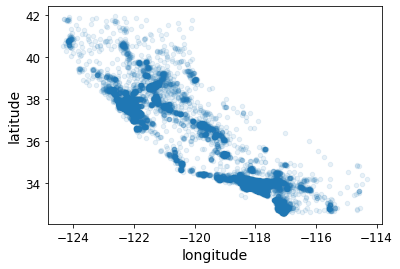

In [30]:
h.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)
plt.show()

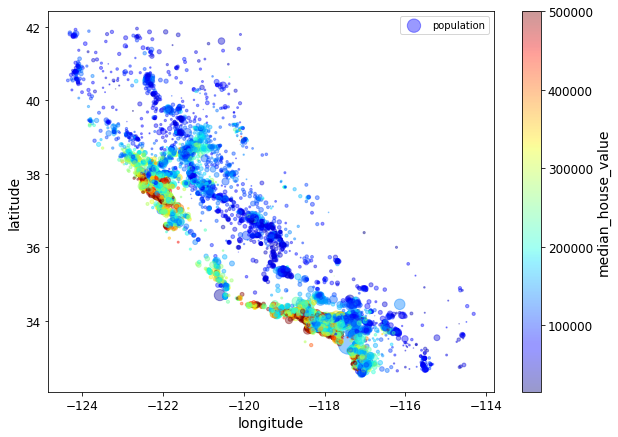

In [31]:
# 주택가격 파악 
h.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=h["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show()


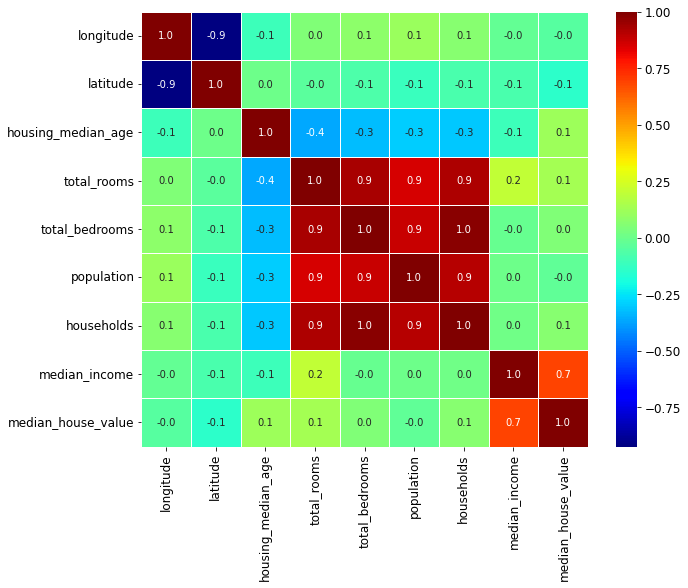

In [32]:
# 변수간 상관관계 파악 

fig ,ax  = plt.subplots(figsize = (10,8))
c = h.corr()
sns.heatmap(c , annot = True , fmt ='.1f' , linewidths  = .5 , cmap = 'jet')
plt.show()

In [33]:
# median_house_value 상관관계 파악 

corr_matrix = h.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

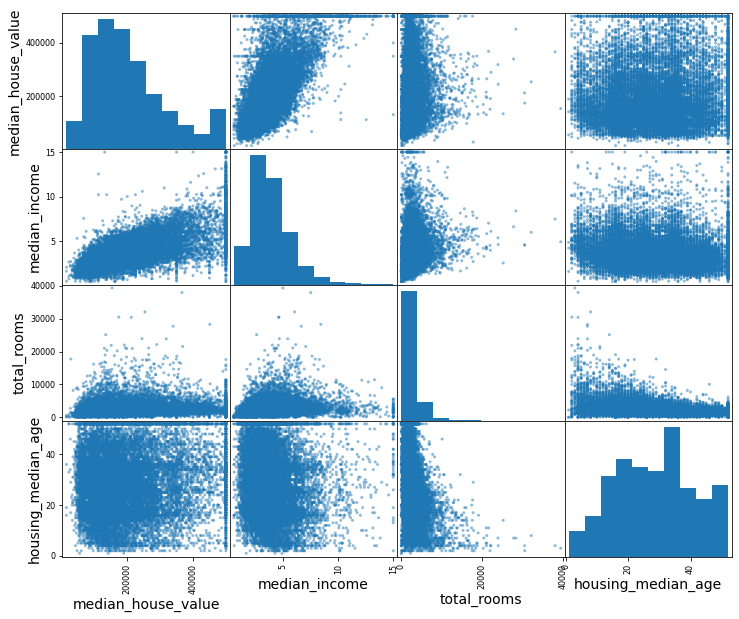

In [34]:
# 목표변수와 상관관계가 있는 수치형 변수 산점도 

from pandas.plotting import scatter_matrix

a = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

scatter_matrix(h[a] , figsize = (12, 10))
plt.show()

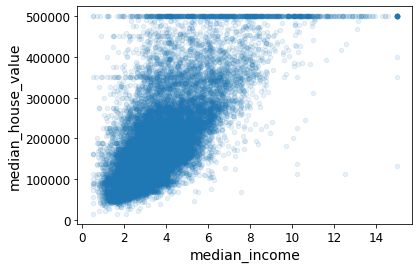

In [35]:
h.plot(kind = 'scatter',x = 'median_income' ,y = 'median_house_value' ,alpha = 0.1)
plt.show()

### 특성조합 

In [36]:
h.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [37]:
# 특정 구역의 방 개수는 얼마나 많은 가구 수가 있는 지 모른다면 유용하지 않는다. 필요한 것은 가구당 방 개수 
# 전체 침실 갯수 보다 방개수와 비교 필요
# 가구당 인원 

h["rooms_per_household"] = h["total_rooms"]/h["households"]
h["bedrooms_per_room"] = h["total_bedrooms"]/h["total_rooms"]
h["population_per_household"]=h["population"]/h["households"]

In [38]:
corr_matrix = h.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

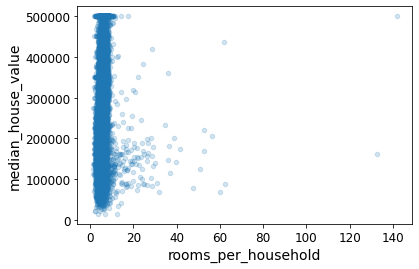

In [39]:
h.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.show()

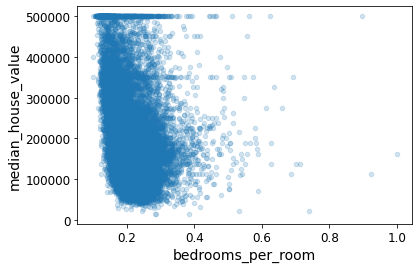

In [40]:
h.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value",
             alpha=0.2)
plt.show()

In [41]:
h.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


### 머신러닝 알고리즘을 위한 데이터 준비 
작업을 수동으로 하는 대신 함수를 만들어 자동화 해야하는 이유
* 어떤 데이터셋에 대해서도 데이터 변환을 손쉽게 반복할 수 있다.(다음번에 새로운 데이터셋을 사용할때)
* 향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축하게 된다.
* 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전에 변환시키는데 이 함수를 사용할 수 있다.
* 여러가지 데이터변환을 쉽게 시도해볼 수 있고 어떤 조합이 가장 좋은지 확인하는데 편리하다.

In [42]:
h = strat_train_set.drop('median_house_value' ,axis = 1)
h_label = strat_train_set.median_house_value

### 데이터 정제(preprocessing)
대부분의 머신러닝 알고리즘은 누락된 특성을 다루지 못한기 때문에 처리필요
* 해당 구역을 제거 
* 전체 특성을 제거
* 어떤 값으로 채운다.(0 , 평균, 중간값등)




In [43]:
sample_incomplete_rows = h[h.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [44]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [45]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [46]:
median = h["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [47]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [48]:
# simpleimputer 

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'median')

In [49]:
# 수치형 특성에만 적용되기 때문에 범주형 제거

housing_num = h.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [50]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [51]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [52]:
# 값 비교
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [53]:
X = imputer.transform(housing_num)

In [54]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [55]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [56]:
imputer.strategy

'median'

In [57]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


### 텍스트와 범주형 특성 다루기

In [58]:
housing_cat = h[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


특성은 범주형 특성으로 5개의 범주를 가진 텍스트 특성입니다. 대부분의 머신러닝 알고리즘은 수치형 데이터를 다루므로 이 범주형 특성을 텍스트에서 숫자형 데이터로 변환시키는 작업이 필요  

작업을 위해 sklearn의 OrdinalEnoder를 사용하겠습니다. 이는 문자열 데이터를 정수형 데이터로 순서대로 변환하는 기능을 지원  


In [59]:
# 범주형을 수치형으로 변환 
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_endcoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_endcoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

범주형 특성들이 수치형 특성으로 변환된 결과  

이 표현 방식에는 문제점이 존재합니다.  

대부분의 머신러닝 알고리즘은 가까이 있는 두 값이 떨어져 있는 거리를 기준으로 삼아 학습을 진행하기 때문에 거리적으로 가까운 특성이 아닌 수치형으로 변환된 특성으로 특성간의 거리를 측정한다는 것입니다.   

예를 들어 Bad, Average, Good, Excellent와 같은 순서가 있는 카테고리의 경우는 괜찮지만 ocean_proximity 특성의 경우 <1H OCEAN, INLAND 의 비슷함보다 <1H OCEAN 와 NEAR OCEAN 이 훨씬 의미적으로 비슷하기 때문입니다.  
  
문제의 해결책은 카테고리별 이진 특성을 만들어 해결하는 것입니다.  
  
 방법을 원-핫 인코딩(one-hot encoding)이라고 부릅니다. 이따금 새로운 특성을 더미 특성이라고도 부릅니다.  
  
 sklearn에서는 이러한 범주의 값을 원 핫 벡터로 변환하기 위한 OnOneHotEncoder 클래스를 제공  

In [60]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

OneHotEncoder의 결과물은 사이파이 희소 행령입니다. 이는 수천개의 카테고리가 있는 경우에는 매우 효율적으로 작동할 수 있습니다. 이런 특성을 원-핫 인코딩하면 열이 수천개인 행렬로 변하고 각 행은 1이 하나뿐인 행렬로 나타나게 됩니다. 따라서 0을 모두 메모리에 저장하는 것은 낭비이므로 0이 아닌 원소의 위치만 저장하는 희소행렬로 출력됩니다. 하지만 필요에 따라서 toarary()메소드 혹은 sparse=False 파라미터를 사용해 밀집 배열로 변환할 수 있습니다 .



In [61]:
housing_cat_1hot.toarray() # toarray() 메서드를 사용해 밀집 배열로 변환

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [62]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [63]:
# 변환기 생성 
# sklearn.base의 TransformerMixin을 상속하면 fit, transform메서드만 만들어도 자동으로 fit_transform()메서드를 자동으로 생성해준다.
#sklearn.base의 BaseEstimator를 상속하면 하이퍼파라미터 튜닝에 필요한 두 메서드 get_params()와 set_params()를 추가로 얻게 된다. 
# (생성자에 *args나 **kargs 사용하면 안됨)


 
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(h.to_numpy())

간단하게 인덱스 (3, 4, 5, 6)을 하드코딩했지만 다음처럼 동적으로 처리하는 것이 더 좋다

In [64]:
# get_loc 위치와 값을 혼용해서 사용 가능 

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    h.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

In [65]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(h.columns)+["rooms_per_household", "population_per_household"],
    index=h.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


### 특성 스케일링 
머신러닝 알고리즘은 입력 숫자 특성들의 스케일이 많이 다르면 잘 작동하지 못함, **타깃값에 대한 스케일링은 일반적으로 불필요**

MinMaxScaling(정규화라고도 부른다) 0~1 범위에 들도록 값을 이동하고 스케일을 조정 , 데이터에서 최솟값을 뺀 후 최댓값과 최솟값의 차이로 나누면 된다.  

표준화는 정규화와 다르다. 먼저 평균을 뺀 후 표준편차로 나누어 결과 분포의 분산이 1이 되도록 한다. 표준화는 범위의 상한과 하한이 없어 어떤 알고리즘에서는 문제가 될 수 있다. 그러나 표준화는 이상치에 영향을 덜 받는다.

**모든 변환기에서 스케일링은 전체 데이터가 아니고 훈련데이터에 대해서만 fit()메서드를 적용하여야 한다.** 훈련세트와 테스트세트(또한 새로운 데이터)에 대해 transform()메서드를 사용한다.

### 변환 파이프라인 
변환 단계가 많으면 정확한 순서대로 실행되어야 하는데 연속된 변환을 순서대로 처리할 수 있도록 도와주는 Pipeline 클래스가 있다.

In [66]:
### 숫자 특성 처리 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

imp = SimpleImputer(strategy='median')

step = [('imputer',imp),
         ('attr_adder' , CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())]



num_pipeline = Pipeline(step)

housing_num_tr = num_pipeline.fit_transform(housing_num)

Pipeline은 연속된 단계를 나타내는 이름/추정기 쌍의 목록을 입력으로 받는다. 마지막 단계에는 변환기와 추정기를 모두 사용할 수 있고 그 외에는 모두 변환기여야 한다.(즉 fit_trasform 메서드를 가지고 있어야 한다)

In [67]:
# 하나의 변환기로 각 열마다 변환적용 (수치형, 범주형 범용)
# ColumnTransfomer 사용
#추정기를 사용하면 입력의 다른 열 또는 열 하위 집합을 개별적으로 변환 할 수 있으며 각 변환기에서 생성 된 특성이 연결되어 단일 특성 공간을 형성합니다. 
#이기종 또는 열 형식의 데이터에서 여러 기능 추출 메커니즘 또는 변환을 단일 변환기로 결합하는 데 유용

from sklearn.compose import ColumnTransformer

num_attribute = list(housing_num)
cat_attribute = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num',num_pipeline, num_attribute),
                                   ('cat',OneHotEncoder() , cat_attribute)])

housing_prepared = full_pipeline.fit_transform(h)

수치형 열 이름의 리스트와 범주형 열 이름의 리스트를 만든다. ColumnsTransformer  클래스 객체 생성, 생성자는 튜플의 리스트를 받는다. 각 튜플은 이름, 변환기, 변환기가 적용될 열 이름의 리스트로 이루어 진다.

OnehotEncoder는 희소행렬을 반환하지만 num_pipeline은 밀집행렬을 반환 ,회소행렬과 밀집행렬이 섞여 있을때 ColumnsTransformer는 최종 행렬의 밀집정도를 추정한다.(즉 0인 아닌 원소의 비율). 밀집도가 임곗값(기본적으로 sparse_threshold = 0.3) 보다 낮으면 희소행렬을 반환 

### 모델 선택과 훈련 

In [68]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(housing_prepared, h_label)

LinearRegression()

In [69]:
# 샘플에 적용

some_data = h.iloc[:5]
some_labels = h_label.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)
print('예측 :', reg.predict(some_data_prepared))
print('레이블 :',list(some_labels))

예측 : [ 86208. 304704. 153536. 185728. 244416.]
레이블 : [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [70]:
# RMSE 측정 

from sklearn.metrics import mean_squared_error

h_prediction = reg.predict(housing_prepared)

mse = mean_squared_error(h_label, h_prediction)
rmse = np.sqrt(mse)

print(f'LinearRegression  RMSE : {rmse}')

LinearRegression  RMSE : 68633.40810776998


대부분 구역의 중간 주택가격은 120.000 ~ 265.000 사이다. 예측 오차가 68.628인 것은 만족스럽지 못한 결과 값   
이는 모델이 훈련 데이터에 과소적합된 사례이다. 이 상황은 **특성들이 좋은 예측을 만들 만큼 충분한 정보를 제공하지 못했거나 모델이 충분히 강력하지 못하다는 사실을 말해준다**   
**과소적합을 해결하는 방법은 더 강력한 모델을 선택하거나 훈련 알고리즘에 더 좋은 특성을 주입하거나 모델의 규제를 감소시키는 것**   


In [71]:
# 의사결정나무 알고지름 사용 
# 데이터에서 복잡한 비선형관계를 파악 가능 

from sklearn.tree import DecisionTreeRegressor

t_reg = DecisionTreeRegressor()
t_reg.fit(housing_prepared , h_label)

DecisionTreeRegressor()

In [72]:
h_prediction = t_reg.predict(housing_prepared)

t_mse = mean_squared_error(h_label , h_prediction)
t_rmse = np.sqrt(t_mse)

print(f'DecisionTreeRegressor  RMSE : {t_rmse}')

DecisionTreeRegressor  RMSE : 0.0


RMSE 값이 0이라는 결과는 데이터가 심하게 과대적합된 것으로 보인다. 확신이 되는 모델이 론칭할 준비가 되기 전까지 테스트 세트는 사용하지 않으려도 하므로 훈련세트의 일부분으로 훈련을 하고 다른 일부분은 모델 검증에 사용해야한다.

### 교차검증을 사용한 평가

train_test_split 함수를 사용해 훈련 세트를 더 작은 훈련세트와 검증세트로 나누고 , 더 작은 훈련 세트에서 모델을 훈련시키고 검증 세트로 모델을 평가하는 방법 사용

In [73]:
# k-fold-cross-validation 
# 훈련세트를 폴드라 불리는 10개의 서브셋으로 무작위로 분할, 모델을 10번 훈련하고 평가하는데 매번 다른 폴드를 선택해 평가에 사용하고 나머지 9개 폴드는 
# 훈련에 사용, 10개의 평가 점수가 담긴 배열이 결과로 나온다.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(t_reg, housing_prepared, h_label,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

**교차검증 기능은 scoring 매개변수에(낮을 수록 좋음) 비용함수가 아니라(클수록 좋음) 호용함수를 기대한다. 그래서 평균제곱오차의 반댓값(음숫값)을 계산하는 neg_mean_squared_error 함수를 사용한다**

In [74]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [73200.87079175 69302.09997147 69040.92123613 72116.02075287
 68270.48882033 76922.61558728 71795.33154083 73057.47384653
 67397.23842161 70282.45596443]
평균: 71138.5516933231
표준 편차: 2711.205284608087


In [75]:
lin_scores = cross_val_score(reg, housing_prepared, h_label,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [71800.38078269 64114.99166359 67844.95431254 68635.19072082
 66801.98038821 72531.04505346 73992.85834976 68824.54092094
 66474.60750419 70143.79750458]
평균: 69116.4347200802
표준 편차: 2880.6588594759014


In [76]:
# RandomforestRegressor 사용
# 특성을 무작위로 선택해서 많은 결정트리를 만들고 그 예측을 평균내는 방식으로 작동 

from sklearn.ensemble import RandomForestRegressor

f_reg = RandomForestRegressor(n_estimators=100, random_state=42)
f_reg.fit(housing_prepared, h_label)

RandomForestRegressor(random_state=42)

In [77]:
housing_predictions = f_reg.predict(housing_prepared)
forest_mse = mean_squared_error(h_label, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(f'RandomForestRegressor RMSE : {forest_rmse}')

RandomForestRegressor RMSE : 18650.698705770003


In [78]:
forest_scores = cross_val_score(f_reg, housing_prepared, h_label,
                                scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
평균: 50435.58092066179
표준 편차: 2203.3381412764606


랜덤 포레스트는 괜찮아 보이지만 훈련세트에 대한 점수가 검증세트에 대한 점수보다 훨씬 낮으므로 이 모델도 여전히 훈련세트에 과대적합되어 있다.  
**과대적합을 해결하는 방법은 모델을 간단이 하거나, 규제를 하거나, 더 많은 훈련데이터를 모으는 것이다.** 랜덤포레스트 모델을 더 깊이 들어가기 전에, 여러 종류의 머신러닝 알고리즘으로 하이퍼파라미터 조정에 너무 많은 시간을 들이지 않으면서 다앙한 모델을 시도해봐야 한다. **가능성있는 모델을 선정하는 것이 목적 이다,**

In [79]:
scores = cross_val_score(reg, housing_prepared, h_label, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69116.434720
std       3036.481053
min      64114.991664
25%      67062.723869
50%      68729.865821
75%      71386.234963
max      73992.858350
dtype: float64

In [80]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, h_label)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(h_label, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f'SVM RMSE : {svm_rmse}')

SVM RMSE : 111095.06635291968


In [81]:
# 모델 저장 

import joblib

#joblib.dump(my_model, 'my_model.pkl')
#my_model_loaded = joblib.load('my_model.pkl')

실험한 모델을 모두 저장해두면 필요할 때 쉽게 모델을 복원할 수 있다. 교차검증 점수와 실제 예측값은 믈론 하이퍼파라미터와 훈련된 모델 파라미터 모두 저장해야한다. 여러 모델의 점수와 모델이 만든 오차를 쉽게 비교할 수 있다. 파이썬의 pickle패키지나 큰 넘파이 배열을 저장하는데 효율적인 joblib을 사용해여 사이킷런 모델을 간단하게 저장 할 수 있다.

### 모델 세부 튜닝 

#### 그리드 탐색 (Grid Search)

In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.

grid_search = GridSearchCV(f_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, h_label)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [83]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [84]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다

In [85]:
cvres = grid_search.cv_results_
cvres

{'mean_fit_time': array([0.05859065, 0.19417357, 0.58107247, 0.09988909, 0.32672119,
        0.98733096, 0.13213878, 0.45116782, 1.38373404, 0.17809567,
        0.59951153, 1.79719677, 0.09266467, 0.30729084, 0.1248786 ,
        0.41467285, 0.16469884, 0.53011661]),
 'std_fit_time': array([0.00061164, 0.00209907, 0.00265081, 0.00120109, 0.00289681,
        0.00330673, 0.00129575, 0.00280821, 0.00754147, 0.00296923,
        0.00492112, 0.00837305, 0.00106029, 0.00371594, 0.00208608,
        0.0027572 , 0.00274351, 0.00447269]),
 'mean_score_time': array([0.00293469, 0.00992427, 0.02930903, 0.00290523, 0.00993443,
        0.02874775, 0.00288773, 0.01016107, 0.02980776, 0.00304794,
        0.01014481, 0.03016028, 0.00323868, 0.01159239, 0.00323358,
        0.01174622, 0.00361733, 0.01157799]),
 'std_score_time': array([0.00018423, 0.00093837, 0.00070005, 0.00012348, 0.00026536,
        0.00110626, 0.00014183, 0.0005089 , 0.00136295, 0.0002487 ,
        0.00051574, 0.00160033, 0.00015044, 

In [86]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [87]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.058591,0.000612,0.002935,0.000184,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.194174,0.002099,0.009924,0.000938,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.581072,0.002651,0.029309,0.000700,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.099889,0.001201,0.002905,0.000123,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.326721,0.002897,0.009934,0.000265,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,0.987331,0.003307,0.028748,0.001106,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.132139,0.001296,0.002888,0.000142,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.451168,0.002808,0.010161,0.000509,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,1.383734,0.007541,0.029808,0.001363,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.178096,0.002969,0.003048,0.000249,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


### 랜덤탐색 

그리드 탐색 방법은 비교적 적은 수의 조합을 탐구할 때 괜찮다. 하지만 하이퍼파라미터 탐색 공간이 커지면 RandomizedSearchCV를 사용하는 것이 좋으며, 이는 가능한 모든 조합을 시도하는 대신 각 반복바다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수만큼 평가한다.   

- 랜덤 탐색을 1000회 반복 실행하면 하이퍼파라미터마다 각기 다른 1000개의 값을 탐색(그리드 탐색은 하이퍼파라미터마다 몇 개의 값만 탐색)
- 단순히 반복 횟수를 조절하는 것만으로 하이퍼파라미터 탐색에 투입할 컴퓨팅 자원 제어

In [88]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200), # 범위지정
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(f_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, h_label)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14ec600d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14bf02f70>},
                   random_state=42, scoring='neg_mean_squared_error')

In [89]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


### 최상의 모델과 오차 분석

In [90]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

### 테스트세트로 시스템 평가

In [91]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis= 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test , final_predictions)
final_rmse = np.sqrt(final_mse)

print(f'MSE : {final_mse}')
print(f'RMSE : {final_rmse}')

MSE : 2291849114.7652025
RMSE : 47873.26095812988


In [92]:
# 오차의 신뢰구간 파악 

from scipy import stats 

confidence = .95
squred_errors  = (final_predictions - y_test)**2

# A Student’s t continuous random variable.
np.sqrt(stats.t.interval(confidence , len(squred_errors) -1 ,
                         
                         loc = squred_errors.mean(),
                         
                         # Compute standard error of the mean.
                         scale = stats.sem(squred_errors)))


array([45893.36082829, 49774.46796717])

하이퍼파라미터 튜닝을 많이 했다면 교차 검증을 사용해 측정한 것보다 조금 성능이 낮은 것이 보통이다(시스템이 검증 데이터에서 좋은 성능을 내도록 세밀하게 튜닝되었기 때문에 새로운 데이터셋에는 잘 작동하지 않을 가능성이 크다).이 예제 에서는 성능이 낮아지진 않았지만 이런 경우가 생기더라도 테수투 세트에서 성능 수치를 좋게 하려고 하이퍼파라미터를 튜닝하려 시도해서는 안된다. 그렇게 향상된 성능은 새로운 데이터에 일반화되기 어렵다.